Formula 1

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols
from scipy.stats import norm, probplot
from sklearn.preprocessing import StandardScaler

def time_to_seconds(time_str):
    if ':' in time_str:
        mins, secs = time_str.split(':')
        total_seconds = int(mins) * 60 + float(secs)
    else:
        total_seconds = float(time_str)
    return total_seconds

Get Data from Kaggle this is a very large dataset
https://www.kaggle.com/competitions/f1nalyze-datathon-ieeecsmuj/data <br />
We only want to look at the latest dates to help us see which data we want to prioritize

In [3]:
db_dir = os.getcwd()
pit_stops = pd.read_csv(db_dir + r'/data/pit_stops.csv')
races = pd.read_csv(db_dir + r'/data/races.csv')
drivers = pd.read_csv(db_dir + r'/data/drivers.csv')
results = pd.read_csv(db_dir + r'/data/results.csv')
driver_standings = pd.read_csv(db_dir + r'/data/driver_standings.csv')
qualifying = pd.read_csv(db_dir + r'/data/qualifying.csv')
lap_times = pd.read_csv(db_dir + r'/data/lap_times.csv')
lap_times = lap_times.rename(columns={
    'time': 'lapTime',
    'position': 'lapPosition'})

merged_df = pd.merge(races, pit_stops, on='raceId', how='inner')
df = pd.merge(merged_df, drivers, on='driverId', how='inner')
df = df.drop(columns=['url_x','url_y','number'])

# distinct_raceyear_df = df.drop_duplicates(subset='year').sort_values(by='year', ascending=False)
df_new_merged = pd.merge(df, results, on=['driverId','raceId'], how='inner')
df_new_merged = pd.merge(df_new_merged, driver_standings, on=['driverId','raceId'], how='inner')
df_new_merged = pd.merge(df_new_merged, qualifying, on=['driverId','raceId'], how='inner')
df_new_merged = pd.merge(df_new_merged, lap_times, on=['driverId','raceId'], how='inner')

test = df_new_merged[df_new_merged['year'] == 2023]
test.to_csv('test.csv')
test.info()
# df_new_merged['lapTime'] = df_new_merged['lapTime'].apply(time_to_seconds)
# df_new_merged['totalPitDuration'] = df_new_merged['duration'].apply(time_to_seconds)
# df_new_merged['positionOrder'] = pd.to_numeric(df_new_merged['positionOrder'], errors='coerce')
# df_new_merged['fastestLapSpeed'] = pd.to_numeric(df_new_merged['fastestLapSpeed'], errors='coerce')

# # df_new_merged = df_new_merged.fillna(0)
# df_new_merged.columns

<class 'pandas.core.frame.DataFrame'>
Index: 54939 entries, 37351 to 631393
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   raceId             54939 non-null  int64  
 1   year               54939 non-null  int64  
 2   round              54939 non-null  int64  
 3   circuitId          54939 non-null  int64  
 4   name               54939 non-null  object 
 5   date               54939 non-null  object 
 6   time_x             54939 non-null  object 
 7   fp1_date           54939 non-null  object 
 8   fp1_time           54939 non-null  object 
 9   fp2_date           54939 non-null  object 
 10  fp2_time           54939 non-null  object 
 11  fp3_date           54939 non-null  object 
 12  fp3_time           54939 non-null  object 
 13  quali_date         54939 non-null  object 
 14  quali_time         54939 non-null  object 
 15  sprint_date        54939 non-null  object 
 16  sprint_time        549

## Null Values
<br/>60 Items have null values and we will will need to treat for them

In [8]:
# Dropping redundant or unnecessary columns


# Dropping the columns
cleaned_data = test.drop(columns=[ 'time_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
    'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'time_y',
    'driverRef', 'dob']  # Assuming specific dates like DOB are not necessary for the model
)

def convert_qualifying_time(t):
    if pd.isna(t) or t == '\\N':
        return None  # Return None for missing or placeholder values
    try:
        # Split by ':' if hours are included, otherwise directly handle minutes and seconds
        minutes, seconds = map(float, t.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        # In case there's no minute component and only seconds (unlikely but safer to handle)
        return float(t)

# Apply the adjusted conversion function to q1, q2, q3 columns
for col in ['q1', 'q2', 'q3']:
    cleaned_data[col] = cleaned_data[col].apply(convert_qualifying_time)

# Display the updated columns to verify the conversion
cleaned_data[['q1', 'q2', 'q3']].describe()

,q1,q2,q3
count,54327.000000,39705.000000,25620.000000
mean,82.639836,81.985967,80.130649
std,10.991177,10.743670,10.173912
min,65.116000,64.951000,64.391000
25%,73.874000,73.521000,71.754000
50%,81.840000,79.929000,77.270000
75%,89.706000,89.378000,88.046000
max,128.510000,126.688000,108.841000


In [ ]:
# Selecting relevant features for the model
features = ['year', 'circuitId', 'grid', 'q1', 'q2', 'q3', 'avg_grid_position', 'previous_race_position', 'avg_lap_time']

# Define the target variable: whether the driver finished first
# Assuming 'positionOrder' == 1 indicates a win
cleaned_data['is_winner'] = (cleaned_data['positionOrder'] == 1).astype(int)

# Splitting data into features (X) and target (y)
X = cleaned_data[features]
y = cleaned_data['is_winner']

# Import train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the splits to verify the sizes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [32]:
# Selecting relevant numerical columns for correlation analysis
numerical_columns = [
    'year', 'round', 'circuitId', 'driverId', 'stop', 'lap_x', 'milliseconds_x',
    'grid', 'position_x', 'laps', 'milliseconds_y', 'fastestLap', 'rank', 'fastestLapTime',
    'fastestLapSpeed', 'positionOrder', 'points', 'laps', 'milliseconds', 'lap_y', 'lapPosition'
]

# Creating a subset of the data with the selected numerical columns
numerical_data = df_new_merged[numerical_columns]

# Calculating the correlation matrix
correlation_matrix = numerical_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

KeyError: "['points'] not in index"

Modelling Test

In [4]:
# Function to load data
def load_data(file_path):
    file_path
    return file_path

# Function to run an OLS regression using a formula interface
def run_ols_formula(data, formula):
    model = ols(formula, data).fit()
    return model

def run_and_diagnose_regression(file_path, formula):
    data = load_data(file_path)
    model = ols(formula, data).fit()
    print(model.summary())

    # Generate predictions and residuals
    predictions = model.predict(data)
    residuals = data[formula.split('~')[0].strip()] - predictions  # Extracting response variable from formula

    # Plotting all diagnostics
    plot_residuals(predictions, residuals)
    plot_qq(residuals)
    plot_histogram_with_fit(residuals)
    plot_standardized_residuals(predictions, residuals)
    plot_cooks_distance(model)

# Function to plot residuals
def plot_residuals(predictions, residuals):
    plt.scatter(predictions, residuals, s=2, color='black')
    plt.hlines(0, min(predictions), max(predictions), color='red', linestyles='dashed')
    plt.xlabel("Model Prediction")
    plt.ylabel("Residual")
    plt.title("Residual Plot")
    plt.show()
    print('Mean of Residuals:', residuals.mean())

# Function to plot a Q-Q plot
def plot_qq(residuals):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    probplot(residuals, dist='norm', plot=ax)
    plt.title("Normal Q-Q Plot")
    plt.show()

# Function to plot histogram of residuals with fitted normal distribution
def plot_histogram_with_fit(residuals):
    mean, std = norm.fit(residuals)
    plt.hist(residuals, bins=30, edgecolor='black', density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = f"Fit results: mu = {mean:.2f}, std = {std:.2f}"
    plt.title(title)
    plt.show()

# Function to plot standardized residuals
def plot_standardized_residuals(predictions, residuals):
    # Convert the Pandas Series to a NumPy array and reshape it
    residuals_array = residuals.values.reshape(-1, 1)
    scaler = StandardScaler().fit(residuals_array)
    norm_residuals = scaler.transform(residuals_array)

    plt.scatter(predictions, np.sqrt(np.abs(norm_residuals)), c='black', s=2)
    plt.xlabel("Fitted Values")
    plt.ylabel("Root of Standardized Residual")
    plt.title("Root of Standardized Residuals")
    plt.show()


# Function to plot Cook's distance
def plot_cooks_distance(model):
    fig, ax = plt.subplots(figsize=(12,8))
    sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
    plt.title("Outliers")
    plt.show()

# Example usage
# formula = 'Grocery_Bill ~ N_Adults + Family_Size + Distance_to_Store  + N_Children + Vegetarian + Family_Pet' 
# model = run_ols_formula(data, formula)
# print(model.summary())



#### Position you get in Qualifying (position) will influence the end race Position (Position Order)

                            OLS Regression Results                            
Dep. Variable:          positionOrder   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     9680.
Date:                Mon, 08 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:29:04   Log-Likelihood:                -31260.
No. Observations:               10953   AIC:                         6.252e+04
Df Residuals:                   10951   BIC:                         6.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4510      0.082     42.051      0.0

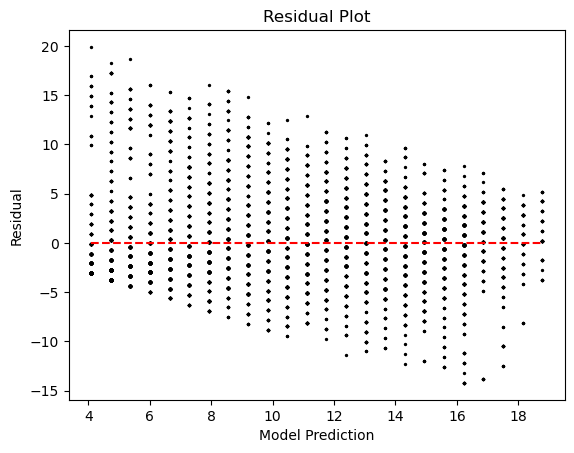

Mean of Residuals: -1.616194421768724e-13


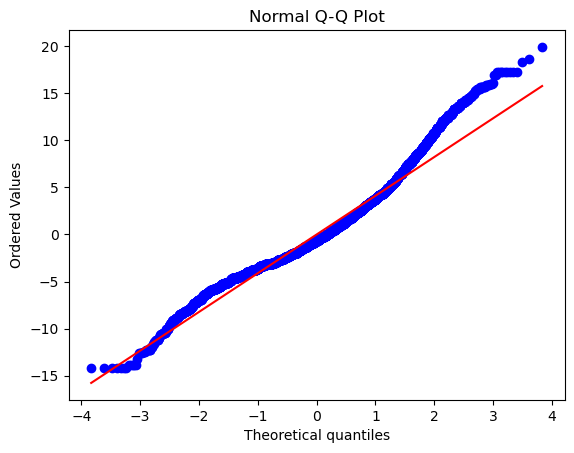

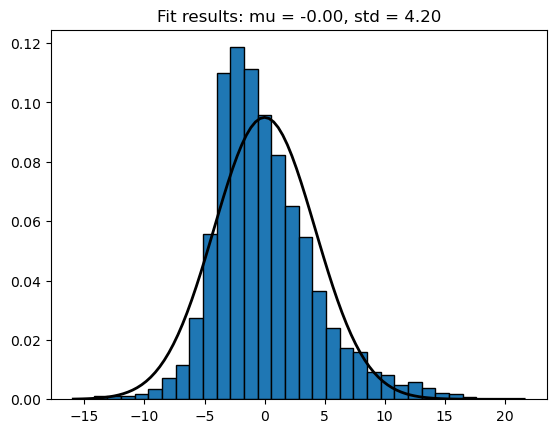

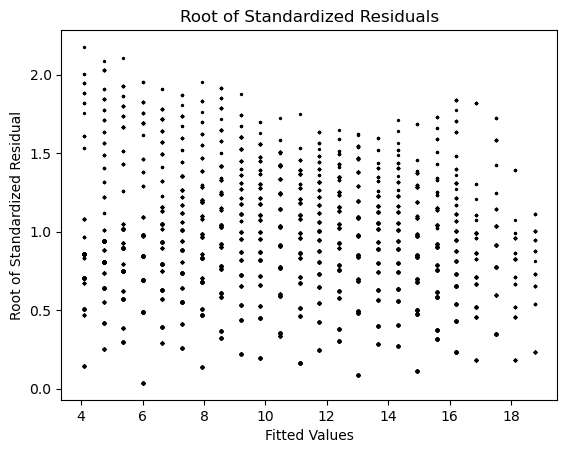

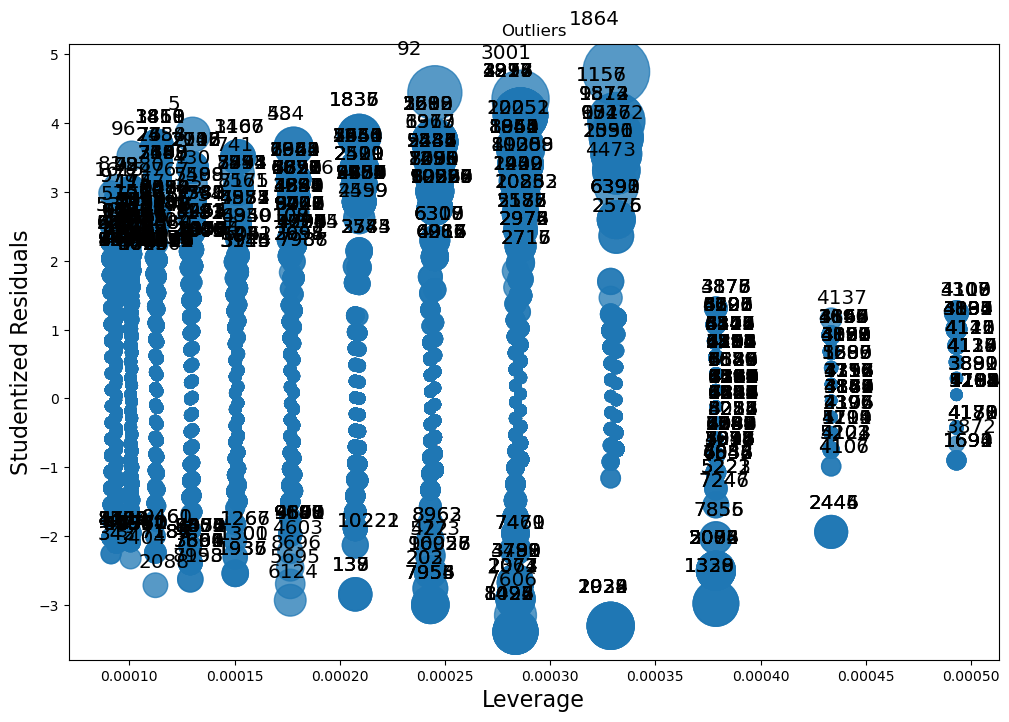

In [7]:
formula = 'positionOrder ~ position' 
run_and_diagnose_regression(df_new_merged,formula)

The Pit Stop Duration and of Race Position

                            OLS Regression Results                            
Dep. Variable:          positionOrder   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     2624.
Date:                Mon, 08 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:31:32   Log-Likelihood:                -31047.
No. Observations:               10953   AIC:                         6.210e+04
Df Residuals:                   10948   BIC:                         6.214e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.7771      0.358  

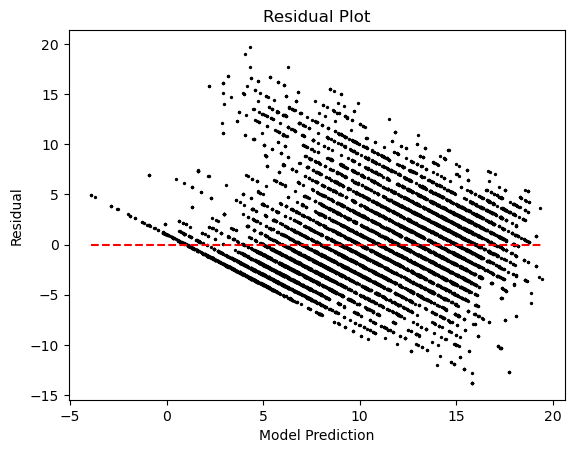

Mean of Residuals: -2.2626825699921196e-13


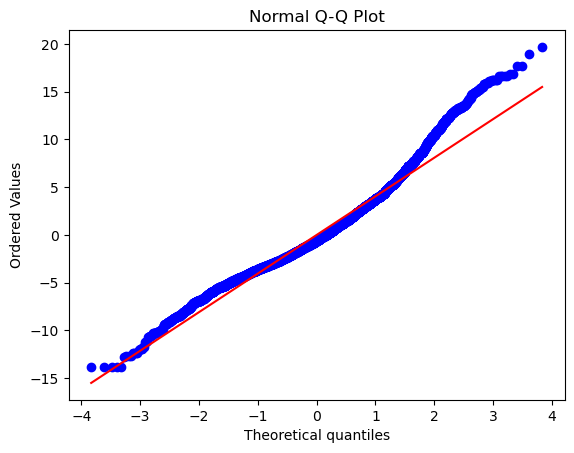

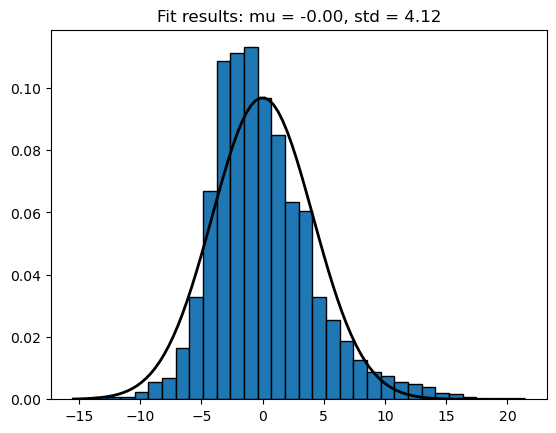

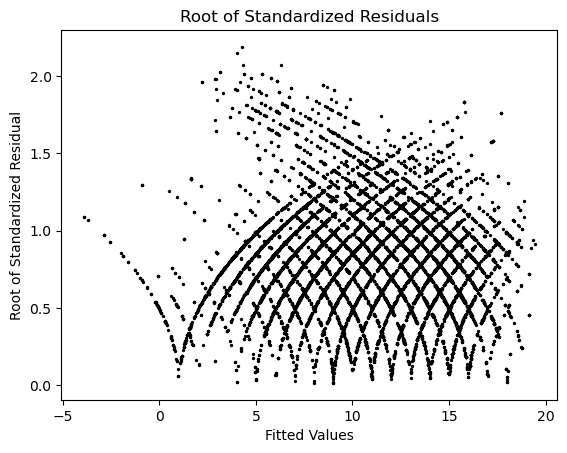

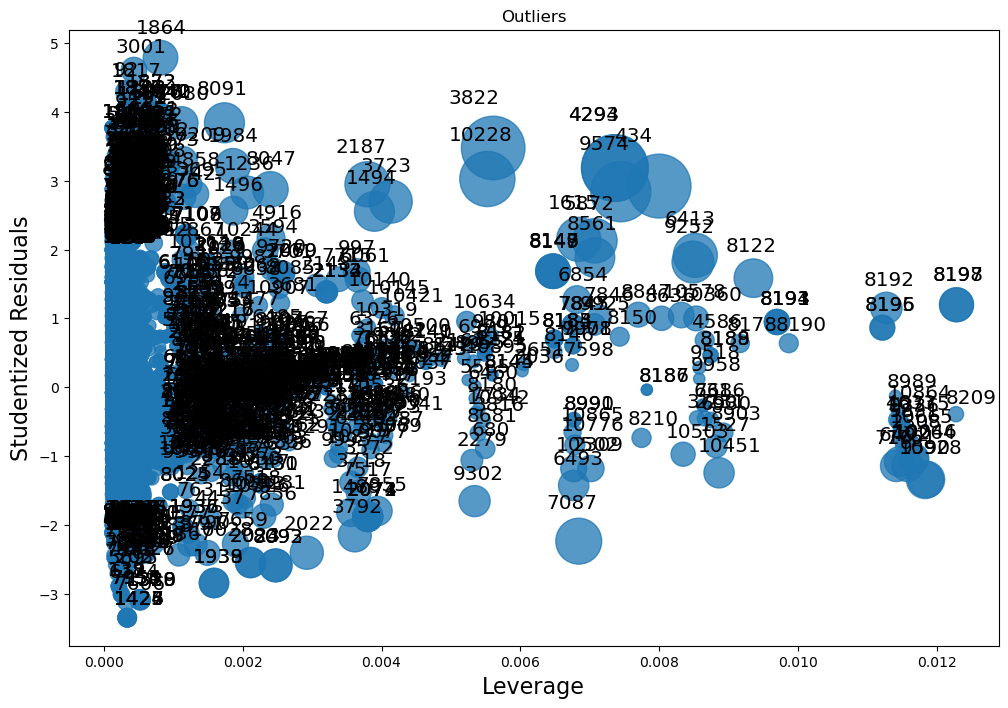

In [8]:
formula = 'positionOrder ~ totalPitDuration + fastestLapSpeed + wins + position' 
run_and_diagnose_regression(df_new_merged,formula)

In [ ]:
formula = 'positionOrder ~ totalPitDuration + fastestLapSpeed + wins + position' 
run_and_diagnose_regression(df_new_merged,formula)
print(model.summary())

In [ ]:
# Correlation analysis between lap of pit stops and race outcome
correlation = df_new_merged['lap'].corr(df_new_merged['positionOrder'])
print(f'Correlation between Lap of Pit Stops and Race Outcome: {correlation}')

Correlation between Lap of Pit Stops and Race Outcome: -0.053381966143573156


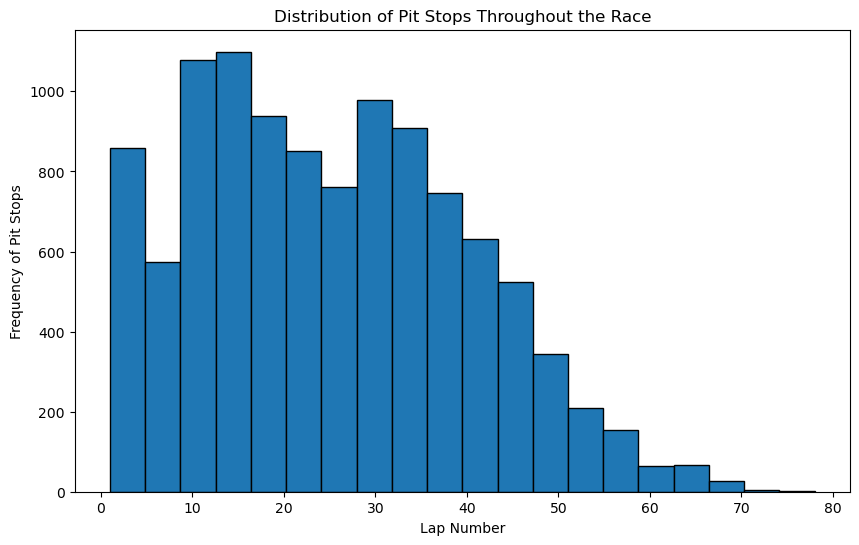

<Figure size 1000x600 with 0 Axes>

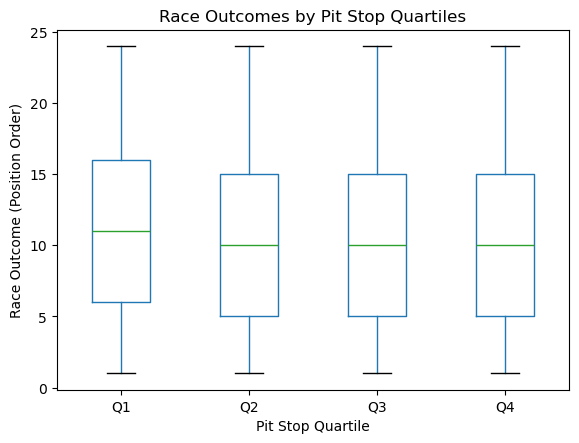

In [ ]:
# Select relevant columns and drop rows with missing values
pit_stop_data = df_new_merged[['lap', 'positionOrder']].dropna()

# Convert the 'lap' column to numeric, forcing errors to NaN
pit_stop_data['lap'] = pd.to_numeric(pit_stop_data['lap'], errors='coerce')

# Drop any remaining rows with NaN values after conversion
pit_stop_data = pit_stop_data.dropna()

# Plotting the frequency of pit stops throughout the race
plt.figure(figsize=(10, 6))
plt.hist(pit_stop_data['lap'], bins=20, edgecolor='black')
plt.title('Distribution of Pit Stops Throughout the Race')
plt.xlabel('Lap Number')
plt.ylabel('Frequency of Pit Stops')
plt.show()

# Group pit stops into quartiles
pit_stop_data['lap_quartile'] = pd.qcut(pit_stop_data['lap'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Box plot of race outcomes by pit stop quartiles
plt.figure(figsize=(10, 6))
pit_stop_data.boxplot(column='positionOrder', by='lap_quartile', grid=False)
plt.title('Race Outcomes by Pit Stop Quartiles')
plt.xlabel('Pit Stop Quartile')
plt.ylabel('Race Outcome (Position Order)')
plt.suptitle('')
plt.show()

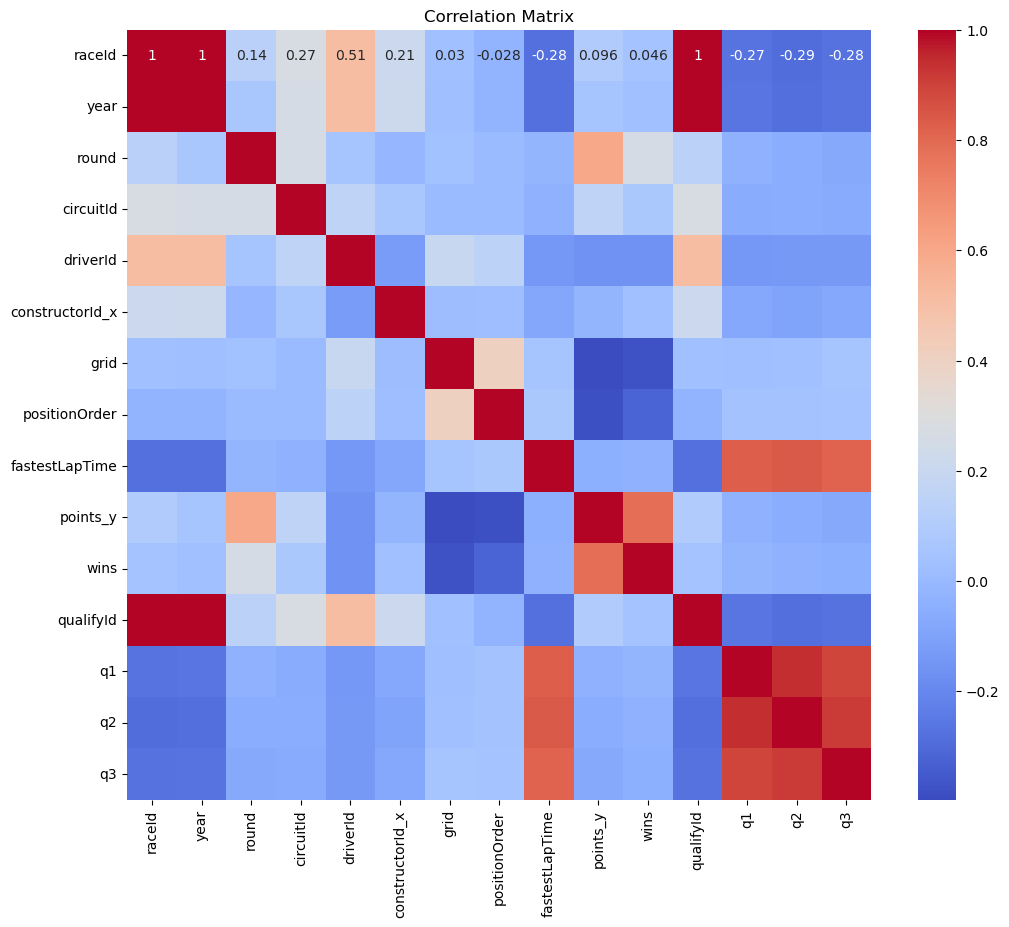

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
relevant_columns = ['raceId', 'year', 'round', 'circuitId', 'driverId', 'constructorId_x', 'grid', 'positionOrder', 'fastestLapTime', 'points_y', 'wins', 'qualifyId', 'q1', 'q2', 'q3']
data = df_new_merged[relevant_columns].dropna()
# # Convert necessary columns to numeric
# for col in ['q1', 'q2', 'q3', 'fastestLapTime']:
#     data[col] = pd.to_numeric(data[col].str.replace(':', ''), errors='coerce')

# Drop any remaining rows with NaN values after conversion
data = data.dropna()

# Calculate correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Latest Race Performance for Each Team:
    constructorId_x  driverId  forename     surname  lap  positionOrder
0               117         4  Fernando      Alonso   27              8
1               117         4  Fernando      Alonso   38              8
2               117       840     Lance      Stroll   26              7
3               117       840     Lance      Stroll   39              7
4               166       816    Jérôme  d'Ambrosio   20             19
..              ...       ...       ...         ...  ...            ...
79                3       858     Logan    Sargeant   38             11
80                1       846     Lando      Norris   27              3
81                1       846     Lando      Norris   39              3
82                1       857     Oscar     Piastri   28              4
83                1       857     Oscar     Piastri   38              4

[84 rows x 6 columns]


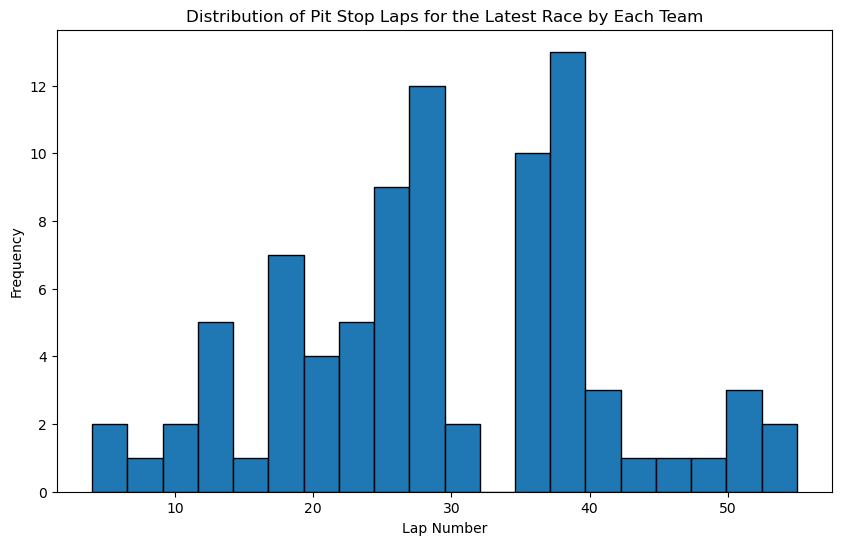

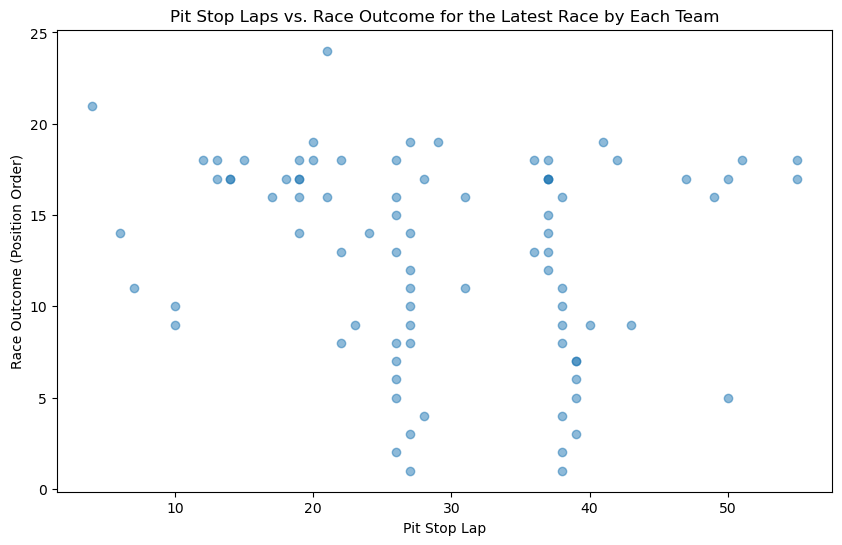

In [11]:
# Identify the latest race for each team
latest_race = df_new_merged.groupby('constructorId_x')['date'].max().reset_index()

# Merge to get the full information for the latest race
latest_race_data = df_new_merged.merge(latest_race, on=['constructorId_x', 'date'])

# Select relevant columns for performance and lap times
latest_race_performance = latest_race_data[['constructorId_x', 'driverId', 'forename', 'surname', 'lap', 'positionOrder']]

# Display the performance data
print("Latest Race Performance for Each Team:")
print(latest_race_performance)

# Plotting the distribution of pit stop laps for the latest race
plt.figure(figsize=(10, 6))
plt.hist(latest_race_performance['lap'], bins=20, edgecolor='black')
plt.title('Distribution of Pit Stop Laps for the Latest Race by Each Team')
plt.xlabel('Lap Number')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of pit stop laps vs. race outcomes for the latest race
plt.figure(figsize=(10, 6))
plt.scatter(latest_race_performance['lap'], latest_race_performance['positionOrder'], alpha=0.5)
plt.title('Pit Stop Laps vs. Race Outcome for the Latest Race by Each Team')
plt.xlabel('Pit Stop Lap')
plt.ylabel('Race Outcome (Position Order)')
plt.show()

Circuit Performance Data:
    circuitId  total_wins  total_points  avg_fastest_lap
0           1          20        3339.0       128.016665
1           2          18        7809.0       142.347891
2           3          32       13392.0       132.114089
3           4          33       18019.0       125.871959
4           5           6        5682.5       134.100124
5           6          14       11178.0       118.454003
6           7          23       15706.0       118.091793
7           9          29       26296.0       134.142894
8          10          13       15281.0       119.784860
9          11          31       32412.0       124.738891
10         12           5        3994.0       144.212158
11         13          22       26800.0       152.210600
12         14          16       22867.5       126.467653
13         15          23       33299.0       150.749561
14         17          24        7500.0       140.313319
15         18          33       66139.0       116.227377
16   

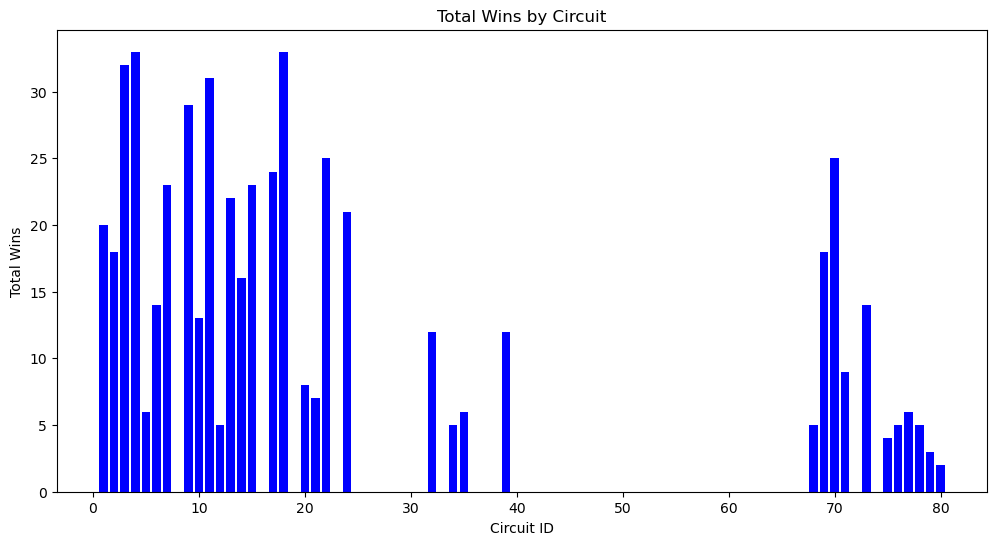

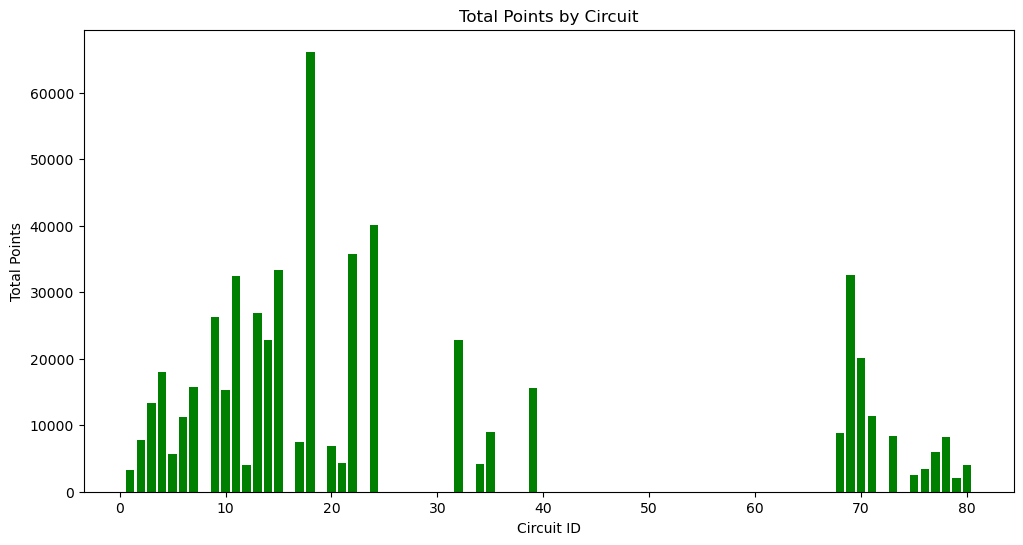

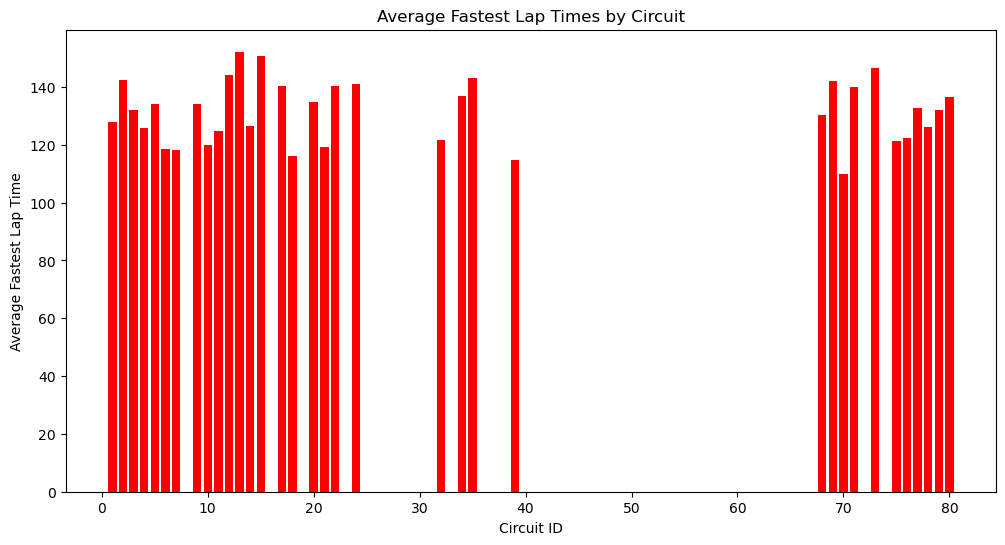

In [18]:
circuit_data = df_new_merged[['circuitId', 'driverId', 'constructorId_x', 'positionOrder', 'fastestLapTime', 'points_y']].dropna()

# Convert the 'fastestLapTime' column to numeric, forcing errors to NaN
circuit_data['fastestLapTime'] = pd.to_numeric(circuit_data['fastestLapTime'].str.replace(':', ''), errors='coerce')

# Drop any remaining rows with NaN values after conversion
circuit_data = circuit_data.dropna()

# Aggregate data by circuit
circuit_performance = circuit_data.groupby('circuitId').agg(
    total_wins=('positionOrder', lambda x: (x == 1).sum()),
    total_points=('points_y', 'sum'),
    avg_fastest_lap=('fastestLapTime', 'mean')
).reset_index()

# Display the aggregated data
print("Circuit Performance Data:")
print(circuit_performance)

# Plotting total wins by circuit
plt.figure(figsize=(12, 6))
plt.bar(circuit_performance['circuitId'], circuit_performance['total_wins'], color='blue')
plt.title('Total Wins by Circuit')
plt.xlabel('Circuit ID')
plt.ylabel('Total Wins')
plt.show()

# Plotting total points by circuit
plt.figure(figsize=(12, 6))
plt.bar(circuit_performance['circuitId'], circuit_performance['total_points'], color='green')
plt.title('Total Points by Circuit')
plt.xlabel('Circuit ID')
plt.ylabel('Total Points')
plt.show()

# Plotting average fastest lap times by circuit
plt.figure(figsize=(12, 6))
plt.bar(circuit_performance['circuitId'], circuit_performance['avg_fastest_lap'], color='red')
plt.title('Average Fastest Lap Times by Circuit')
plt.xlabel('Circuit ID')
plt.ylabel('Average Fastest Lap Time')
plt.show()